In [1]:
import os
from glob import glob
from utils.custom_utils import RetrieveData, show_images
import pandas as pd
import random as rd
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import transforms, utils
from torchvision.io import read_image

In [2]:
DataURL='https://tinyurl.com/mr2yc5nx'

RetrieveData(DataURL)
image_path='./data/images_gz2/images'

In [3]:
'''
class GalaxyZoo2(Dataset):
    def __init__(self, img_dir, transform=None, train=True):
        self.transform = transform
        self.img_dir = img_dir
        
        images=glob(os.path.join(img_dir,'*.jpg'))
        rd.shuffle(images)
        
    
        cut=int(0.1*len(images)/10000)
        if train:
            self.images = images[:cut]
        else:
            self.images = images[cut:]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        img_path=self.images[index]
        image = read_image(img_path)/255
        image = image.float()
        if self.transform:
            image = self.transform(image)
        return image
'''

#we simply define the dataset

class GalaxyZoo2(Dataset):
    def __init__(self, img_dir, transform=None, train=None):
        self.transform = transform
        self.img_dir = img_dir
        
        images = glob(os.path.join(img_dir,'*.jpg'))
        rd.shuffle(images)
        
        cut = int(0.1*len(images)/10)
        if train==True:
            self.images = images[:cut]
        elif train==False:
            self.images = images[cut:]
        else:
            self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = self.images[index]
        with Image.open(img_path) as im:
            if self.transform:
                im = self.transform(im)
            return im.float()/255

torch.Size([4, 3, 424, 424])


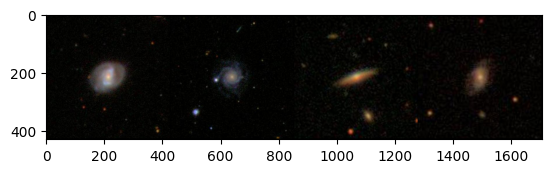

In [4]:
#check that dataset is OK and has been correctly loaded
trainset=GalaxyZoo2(image_path, transform=transforms.PILToTensor())
trainloader=DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #work on cuda

print(f'this instance use {device}')

torch.manual_seed(100)


image_size = 28 #images are 424*424, but we reduce considerably the quality
input_channels = 3 #bc images are RGB in this case (the corresponding tensors are of size [3,424,424])
batch_size = 12 #try to chnage later

#hyperparameters of the NN specifically
input_features = input_channels*image_size*image_size # RGB pixel (dim=3)* 424*424 image
output_features = 32 # size of output of encoder = input of decoder
hidden_features = 10 # arbitrary
hidden_features2 = 5 # arbitrary
hidden_features3 = 1 # arbitrary
latent_space_size = 20 #size of the latent space --> arbitrary
learning_rate = 1e-3 # arbitrary
num_epochs = 10 # arbitrary

model_name = "CNN_GAN"

#transforms.Normalize(0.5,0.5),transforms.Resize([image_size,image_size]),),
T = transforms.Compose([transforms.PILToTensor(),transforms.Resize([image_size,image_size]),])

#directory = ""
#checkpoint = f"{directory}/{model_name}.pt"

this instance use cuda


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([12, 3, 28, 28])


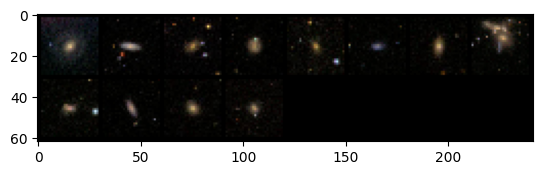

In [6]:
#check that dataset is OK and has been correctly loaded
trainset=GalaxyZoo2(image_path, transform=T)
trainloader=DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

In [34]:
class CNN_GAN(nn.Module):
  #creates an image from a noise
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            ############### conv part ###############
            #try convolutional but with a high depth this time
            nn.Linear(6272,6272), #transform the noise input
            nn.ReLU(),

            nn.Unflatten(0,[1,128,7,7]), #transform into a matrix

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,3,1,padding='same'),
            
            nn.Sigmoid()
            )
    '''
    nn.Linear(6272,6272),
    nn.ReLU(),
    nn.Unflatten(0,[1,128,7,7]),
    nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,3,1,padding='same'),
    '''
    def forward(self, x):
      return self.net(x)

class Discriminator(nn.Module):
  #discriminator, its objective it to determine if an image is a galaxy or not
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ############### conv part ###############
            nn.Conv2d(3,32,5),
            nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Conv2d(64,128,5),
            nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Conv2d(128,256,5),
            nn.ReLU(),

            nn.Flatten(),
            nn.Dropout(p=0.2),
            
            nn.Linear(36864,1),
            
            nn.Sigmoid()
            )
      
    def forward(self, x):
      return self.encoder(x)

torch.Size([1, 3, 28, 28])


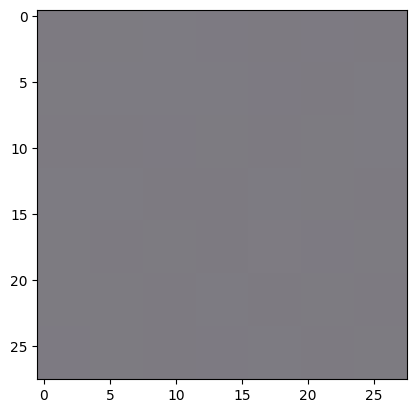

tensor([[0.5027],
        [0.5025],
        [0.5018],
        [0.5044],
        [0.5042],
        [0.5036],
        [0.5020],
        [0.5034],
        [0.5025],
        [0.5020],
        [0.5023],
        [0.5033]], device='cuda:0', grad_fn=<SigmoidBackward0>)


'\ntest_image=next(iter(trainloader))\ntest_image#.to(device)\nprint(test_image.shape)\ntest=model(test_image.to(device))\n#show_images(utils.make_grid(test))\nprint(test.shape)\n'

In [35]:
#trainset definition

trainset = GalaxyZoo2(image_path, transform=T, train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#model = MLP_VAE(input_dim=input_features).to(device)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#GPUtil.showUtilization()
model = CNN_GAN().to(device)
disc = Discriminator().to(device)

#model = nn.DataParallel(model, gpu_ids = [0,1,2])

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#choose of the different optimizer for the training
g_opt = optim.Adam(model.parameters(), lr=learning_rate)
d_opt = optim.Adam(disc.parameters(), lr=learning_rate)
g_loss = nn.BCELoss()
d_loss = nn.BCELoss()


#print a test image
test = model(torch.randn(7*7*128).to(device))
print(test.shape)
show_images(utils.make_grid(test))

test_image=next(iter(trainloader))
result = disc(test_image.to(device))
print(result)

'''
test_image=next(iter(trainloader))
test_image#.to(device)
print(test_image.shape)
test=model(test_image.to(device))
#show_images(utils.make_grid(test))
print(test.shape)
'''

In [36]:
def train(num_epochs):
    """
    Train the model (GAN) onto the data in the trainloader
    """
    train_avg_loss = []
    
    for i in range(num_epochs):
        train_losses = []
        real_images = next(iter(trainloader)) #take a truth image
        fake_images = torch.rand([batch_size,3,28,28]) #creates fake images with only noise

        real_images = real_images.to(device)
        fake_images = fake_images.to(device)
        
        #define the size of the vectors
        y_d_true = torch.ones(batch_size)
        y_d_false = torch.ones(batch_size)

        for j in range(batch_size) : #test the discriminant on the real/false images
          y_d_true[j] = disc(torch.unsqueeze(real_images[j,:,:,:],-4))
          y_d_false[j] = disc(torch.unsqueeze(fake_images[j,:,:,:],-4))

        #define the score that the discriminant has to produce with a little noise
        y_true = torch.zeros(batch_size) + 0.15*torch.rand(batch_size)
        y_false = torch.ones(batch_size) - 0.15*torch.rand(batch_size)
        
        #creates the final vectors for the loss
        y_realfake = torch.cat((y_true,y_false),0)
        y_d_realfake = torch.cat((y_d_true,y_d_false),0)

        L_d = d_loss(y_realfake, y_d_realfake) #compute the loss

        #apply the optimizer
        d_opt.zero_grad()
        L_d.backward()
        d_opt.step()

        #train the generator
        for j in range(batch_size) :
          gen_images = model(torch.rand(7*7*128).to(device))
          L_g = disc(gen_images)

          g_opt.zero_grad()
          L_g.backward()
          g_opt.step()
          

        train_avg_loss.append(L_d)
    return train_avg_loss
          

In [37]:
import warnings
warnings.filterwarnings("ignore")

"\nmodel=model.to(device)\n\ntrain_avg_loss = train(num_epochs)\n\nfig = plt.figure()\n\nplt.plot(train_avg_loss)\nplt.title('ELBO loss of the VAE')\nplt.xlabel('Iterations')\nplt.ylabel('Loss (ELBO)')\n\nplt.show()\n"

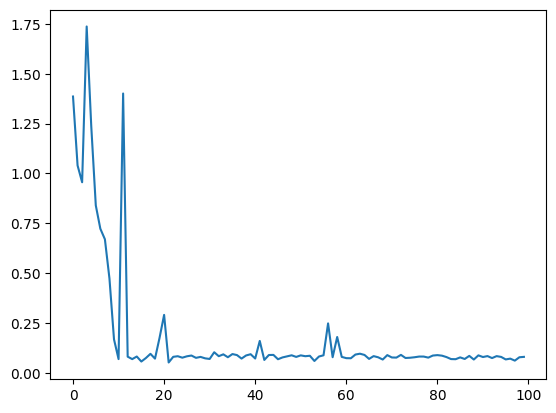

In [38]:
num_epochs=100 #100 has been chosen for the presentation, but even on 10 000 epochs the algorithm was still disappointing
L = train(num_epochs)
plt.plot(torch.tensor(L))

'''
model=model.to(device)

train_avg_loss = train(num_epochs)

fig = plt.figure()

plt.plot(train_avg_loss)
plt.title('ELBO loss of the VAE')
plt.xlabel('Iterations')
plt.ylabel('Loss (ELBO)')

plt.show()
'''

In [39]:
 def train_GAN(num_epochs):
    """
    Train only the generator, the discriminator is assumed to be correct
    """
    train_avg_loss = []
    
    for i in range(num_epochs):
        for j in range(batch_size) :
          gen_images = model(torch.rand(7*7*128).to(device))
          L_g = disc(gen_images)

          g_opt.zero_grad()
          L_g.backward()
          g_opt.step()
          

        train_avg_loss.append(L_g)
    return train_avg_loss



Text(0, 0.5, 'Average Loss')

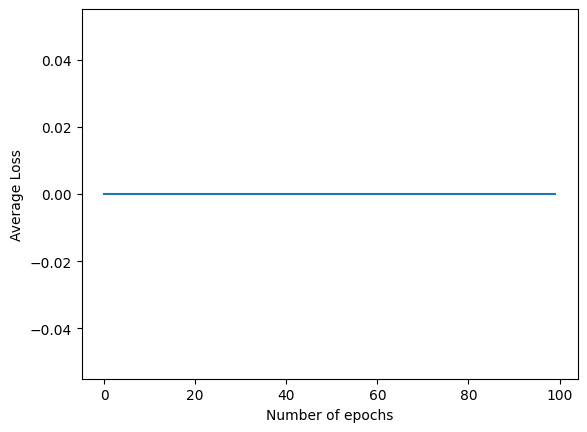

In [42]:
plt.plot(torch.tensor(L))
plt.xlabel('Number of epochs')
plt.ylabel('Average Loss')

torch.Size([1, 3, 28, 28])


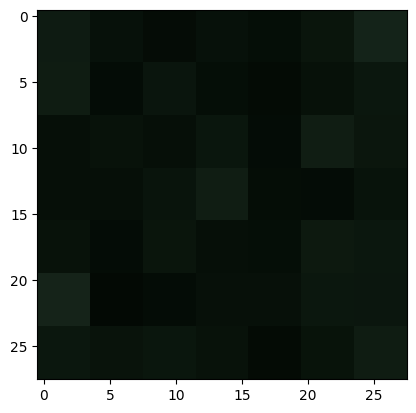

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [43]:
#show an image of the output, as seen, it is not what we are aiming for

test = model(torch.randn(7*7*128).to(device))
print(test.shape)
show_images(utils.make_grid(test))

test_image=next(iter(trainloader))
result = disc(test_image.to(device))
print(result)